<a href="https://colab.research.google.com/github/SiddharthPany/artificial-intelligence/blob/master/session6/Session6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


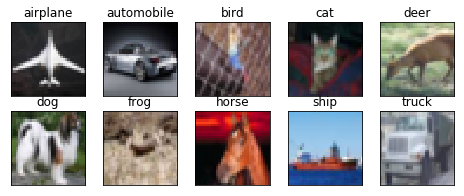

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)
  
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [2]:
from keras.regularizers import l2
from keras.utils import plot_model
from keras.layers import Input
from keras.layers import SeparableConv2D
from keras.layers import Concatenate
from keras.utils import plot_model
from keras.models import Model


weight_decay = 1e-4
# Define the model

input = Input(shape=(32, 32, 3))
# normal convolution...
x = Convolution2D(16,(3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(input) # RF : 3
x = BatchNormalization()(x)
x = Dropout(0.01)(x)

# spatially seperable convolution....
y = Convolution2D(32,(3, 1), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
y = Convolution2D(32,(1, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(y)    # RF : 5
y = BatchNormalization()(y)
y = Dropout(0.01)(y)

# normal convolution...
z = Convolution2D(64,(3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(y) # RF : 7
z = BatchNormalization()(z)
z = Dropout(0.01)(z)

# Transition layer.....
O = Convolution2D(32,(1, 1), activation='relu', kernel_regularizer=l2(weight_decay))(z)  
O = MaxPooling2D(pool_size=(2, 2))(O)                                                        # Output : 16*16*32
O = Dropout(0.10)(O)

# depth wise convolution.....
p = SeparableConv2D(32,(3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(O)
p = BatchNormalization()(p)
p = Dropout(0.01)(p)

# grouped convolution.....
g10 = Convolution2D(64,(3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(p)  
g10 = BatchNormalization()(g10)
g10 = Dropout(0.01)(g10)

g11 = Convolution2D(64,(5, 5), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(p)
g11 = BatchNormalization()(g11)
g11 = Dropout(0.01)(g11)

g12 = Concatenate(axis = -1)([g10,g11]) # output : channels = sum of channels , axis = -1 depth wise . RF is maximum...


# Transition layer.....
O1 = Convolution2D(32,(1, 1), activation='relu', kernel_regularizer=l2(weight_decay))(g12)  
O1 = MaxPooling2D(pool_size=(2, 2))(O1)                                                        # Output : 8*8*32
O1 = Dropout(0.10)(O1)

# grouped convolution......

g20 = Convolution2D(64,(3, 3), dilation_rate=(1, 1) ,activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(O1)    # RF : 15
g20 = BatchNormalization()(g20)
g20 = Dropout(0.01)(g20)

g21 = Convolution2D(64,(5, 5), dilation_rate=(2, 2) ,activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(O1)
g21 = BatchNormalization()(g21)
g21 = Dropout(0.01)(g21)

g22 = Concatenate(axis = -1)([g20,g21]) # output : channels = sum of channels , axis = -1 depth wise . RF is maximum...


# Transition layer.....
O2 = Convolution2D(10,(8, 8), kernel_regularizer=l2(weight_decay))(g22)

#O3 = Convolution2D(10,(1, 1), activation='relu', kernel_regularizer=l2(weight_decay))(O2)

x7 = Flatten()(O2)
x8 = Activation('softmax')(x7)

model = Model(inputs=input, outputs=x8)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize layers
print(model.summary())
# plot graph
plot_model(model)





W0625 02:04:09.070077 140008342321024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 02:04:09.115461 140008342321024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 02:04:09.124891 140008342321024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 02:04:09.179418 140008342321024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0625 02:04:09.180273 1400083423

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
W0625 02:04:23.978336 140008342321024 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions fo

Epoch 1/50
390/390 [==============================] - 31s 80ms/step - loss: 1.7592 - acc: 0.4225 - val_loss: 2.0012 - val_acc: 0.4633
Epoch 2/50
390/390 [==============================] - 25s 65ms/step - loss: 1.2938 - acc: 0.5618 - val_loss: 1.2122 - val_acc: 0.6110
Epoch 3/50
390/390 [==============================] - 25s 65ms/step - loss: 1.1125 - acc: 0.6259 - val_loss: 1.2815 - val_acc: 0.6067
Epoch 4/50
390/390 [==============================] - 26s 66ms/step - loss: 0.9864 - acc: 0.6669 - val_loss: 0.9321 - val_acc: 0.7011
Epoch 5/50
390/390 [==============================] - 25s 65ms/step - loss: 0.9076 - acc: 0.7004 - val_loss: 0.8609 - val_acc: 0.7225
Epoch 6/50
390/390 [==============================] - 25s 65ms/step - loss: 0.8531 - acc: 0.7173 - val_loss: 1.1429 - val_acc: 0.6701
Epoch 7/50
390/390 [==============================] - 25s 65ms/step - loss: 0.8079 - acc: 0.7350 - val_loss: 0.8719 - val_acc: 0.7230
Epoch 8/50
390/390 [==============================] - 25s 65ms

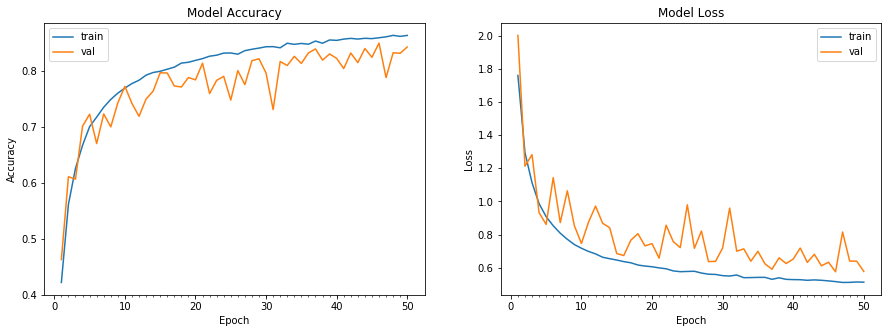

Accuracy on test data is: 84.24


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

datagen = ImageDataGenerator(zoom_range=0.0,
                             rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))